# Compare posteriors - GPJax vs MATLAB

In [6]:
from models import matlabmodel_sin as KOHmodel
from data.dataloadermatlab import DataLoader
from kohgpjax.mappings import mapRto01, map01toR, mapRto0inf, map0inftoR
from MATLAB_mappings import beta2ell

import numpy as np
import matplotlib.pyplot as plt

import arviz

from truefuncs import zeta
eta = zeta

n_warm_up_iter = 600
n_main_iter = 2000

plot_style = {
    'mathtext.fontset': 'cm',
    'font.family': 'serif',
    'axes.titlesize': 10,
    'axes.labelsize': 10,
    'xtick.labelsize': 6,
    'ytick.labelsize': 6,
    'legend.fontsize': 8,
    'legend.frameon': False,
    'axes.linewidth': 0.5,
    'lines.linewidth': 0.5,
    'axes.labelpad': 2.,
    'figure.dpi': 150,
}

**CHANGE THIS AS NECESSARY**

In [7]:
def disc(x):
    return 0.14*np.sin(x*np.pi)

# Load the data

In [8]:
dataloader = DataLoader('data/toy/field_sin.csv', 'data/toy/sim_sin.csv')
data = dataloader.get_data() # loads normalised/standardised data
model = KOHmodel.MatlabModel(*data)

tmax = dataloader.t_max
tmin = dataloader.t_min

In [9]:
traces_matlab = np.loadtxt(f'data/timings/myriad/traces_{n_warm_up_iter}_{n_main_iter+n_warm_up_iter}_matlab.csv', delimiter=',')
traces_matlab = traces_matlab[n_warm_up_iter:]

In [10]:
traces_transformed_matlab = {}
traces_transformed_matlab['theta'] = traces_matlab[:,0]
traces_transformed_matlab['ell_eta_0'] = beta2ell(traces_matlab[:,1]) # beta2ell?
traces_transformed_matlab['ell_eta_1'] = beta2ell(traces_matlab[:,2]) # beta2ell?
# traces_transformed_matlab['ell_delta_0'] = beta2ell(traces_matlab[:,3]) # beta2ell?
traces_transformed_matlab['lambda_eta'] = traces_matlab[:,4]
traces_transformed_matlab['lambda_delta'] = traces_matlab[:,6]
traces_transformed_matlab['lambda_epsilon'] = traces_matlab[:,7]
traces_transformed_matlab['lambda_epsilon_eta'] = traces_matlab[:,5]

params_transformed_matlab = {}
for var, trace in traces_transformed_matlab.items():
    params_transformed_matlab[var] = np.mean(trace)
    print(var, ": ", np.mean(trace), '±', np.std(trace))

theta :  0.39656374499999997 ± 0.01599320937226093
ell_eta_0 :  0.2171676671533258 ± 0.005616373371991623
ell_eta_1 :  0.2664318553000008 ± 0.00994250924644508
lambda_eta :  0.031492053500000006 ± 0.009081160950211033
lambda_delta :  9.783319249999998 ± 1.2174127933180419
lambda_epsilon :  387.395235 ± 28.600902832686504
lambda_epsilon_eta :  198637.805 ± 554.0972224934899


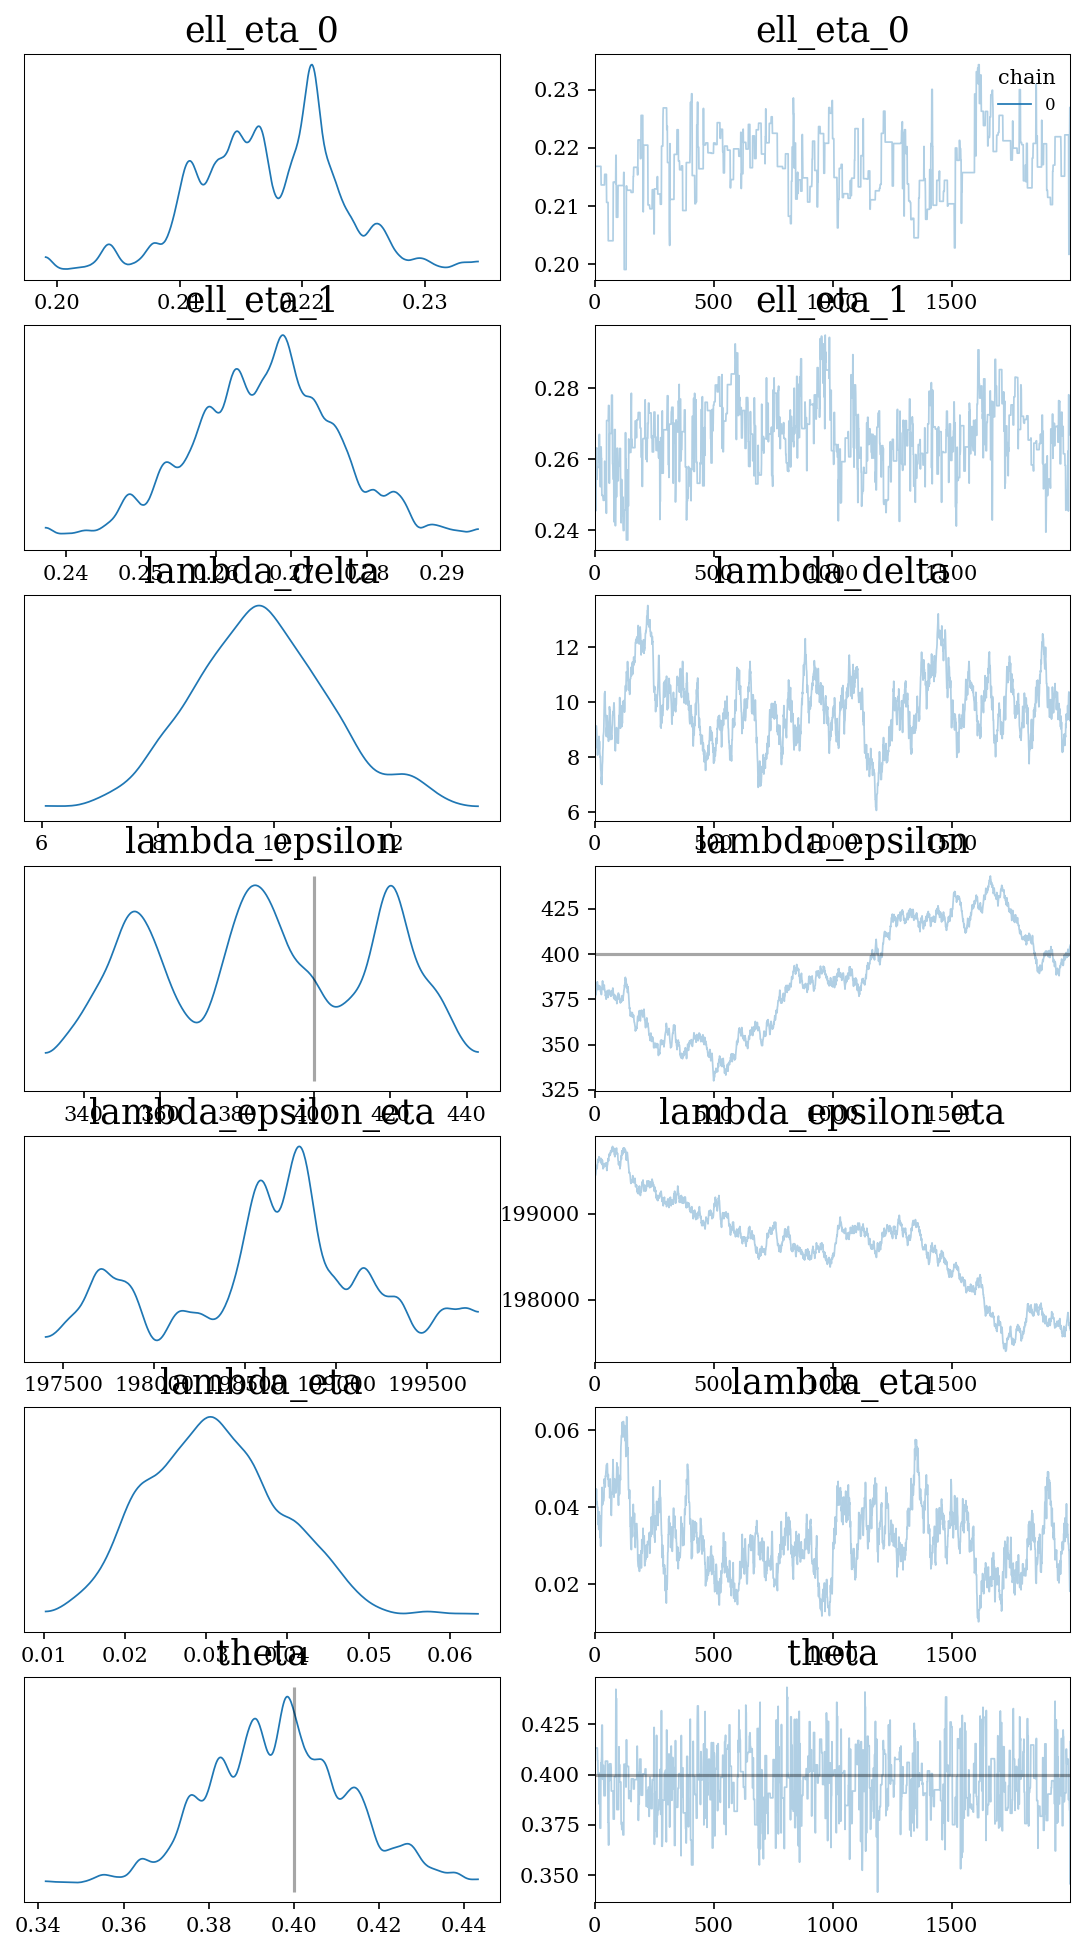

In [11]:
with plt.style.context(plot_style):
    arviz.plot_trace(
        traces_transformed_matlab,
        figsize=(9, 2 * (8)),
        legend=True,
        compact=False,
        lines=(
            ('theta', {}, 0.4),
            ('lambda_epsilon', {}, 1/0.05**2)    
        )
    )
plt.show()

In [12]:
traces = np.load(f'data/timings/myriad/traces_{n_warm_up_iter}_{n_main_iter}.npz')

traces_transformed = {}
for var, trace in traces.items():
    if var == 'hamiltonian':
        continue
    var_name = var.split('m_')[1]
    if var_name == 'theta':
        traces_transformed[var_name] = mapRto01(trace[0])*(tmax-tmin) + tmin
    elif var_name.startswith('ell'):
        traces_transformed[var_name] = mapRto0inf(trace[0])
    elif var_name.startswith('lambda'):
        traces_transformed[var_name] = mapRto0inf(trace[0])

params_transformed = {}
for var, trace in traces_transformed.items():
    params_transformed[var] = np.mean(trace)
    print(var, ": ", np.mean(trace), '±', np.std(trace))

theta :  0.3976227744373375 ± 0.014166619303475758
ell_eta_0 :  0.21732186234765488 ± 0.006260370429250964
ell_eta_1 :  0.26580847635106647 ± 0.00794235608956497
lambda_eta :  0.03095373198522488 ± 0.007910550849740471
lambda_delta :  10.621511042483418 ± 1.3501119925835903
lambda_epsilon :  346.7806707273433 ± 134.94782713828332
lambda_epsilon_eta :  192098.81221270436 ± 14220.623039316022


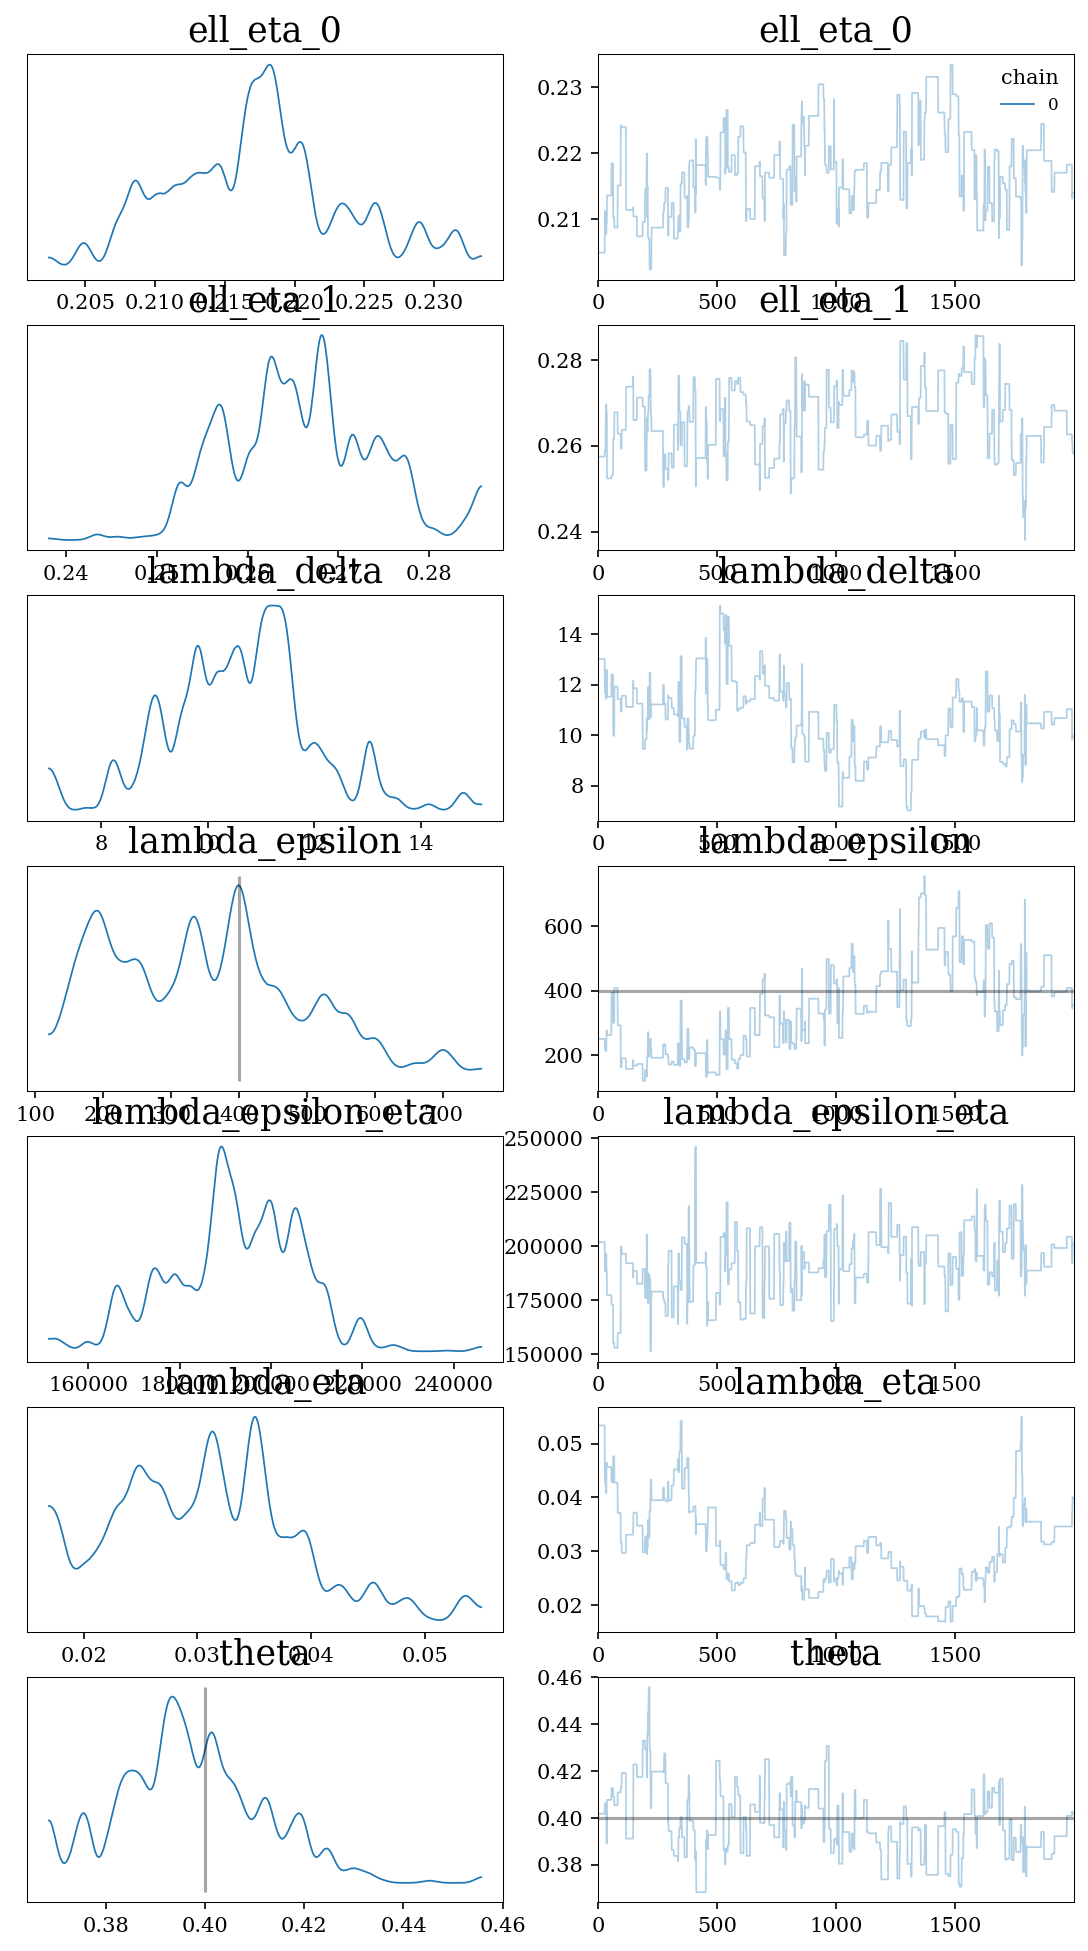

In [13]:
with plt.style.context(plot_style):
    arviz.plot_trace(
        traces_transformed,
        figsize=(9, 2 * (8)),
        legend=True,
        compact=False,
        lines=(
            ('theta', {}, 0.4),
            ('lambda_epsilon', {}, 1/0.05**2)    
        )
    )
plt.show()

# Analyse posterior fit

## Prediction data

In [14]:
xpred = np.linspace(0, 10, 1000) # for predictions

xp_normalised = (xpred-np.min(xpred))/(np.max(xpred)-np.min(xpred))
# theta_transformed = mapRto01(np.mean(traces['theta'])) # transform theta back to [0, 1]
theta_transformed = params_transformed['theta']
theta_transformed_matlab = params_transformed_matlab['theta']

x_test = np.vstack((xp_normalised, theta_transformed*np.ones_like(xp_normalised))).T
x_test_matlab = np.vstack((xp_normalised, theta_transformed_matlab*np.ones_like(xp_normalised))).T
dataset = model.dataset(theta_transformed)
dataset_matlab = model.dataset(theta_transformed_matlab)

## Posterior GPs

In [15]:
param_transform_mici_to_gpjax = lambda x: [
    [ # theta (calibration) parameters
        mapRto01(x[0]),
    ],
    [ # lengthscale parameters
        mapRto0inf(x[1]), 
        mapRto0inf(x[2]), 
    ],
    [ # lambda (variance) parameters
        mapRto0inf(x[3]), 
        mapRto0inf(x[4]), 
        mapRto0inf(x[5]), 
        mapRto0inf(x[6]),
    ]
]

In [16]:
GP_posterior = model.GP_posterior(
    param_transform_mici_to_gpjax(
        [np.mean(x) for x in traces.values()]
    )
)

eta_pred = GP_posterior.predict_eta(
    x_test,
    dataset
)
zeta_pred = GP_posterior.predict_zeta(
    x_test,
    dataset
)
obs_pred = GP_posterior.predict_obs(
    x_test,
    dataset
)


eta_pred_m = dataloader.inverse_transform_y(eta_pred.mean()) # transform back to original scale
eta_pred_v = dataloader.inverse_transform_y_cov(eta_pred.variance()) # transform back to original scale
# eta_pred_m = eta_pred.mean() + dataloader.yc_mean
# eta_pred_v = eta_pred.variance()
eta_pred_sd = np.sqrt(eta_pred_v)

zeta_pred_m = dataloader.inverse_transform_y(zeta_pred.mean()) # transform back to original scale
zeta_pred_v = dataloader.inverse_transform_y_cov(zeta_pred.variance()) # transform back to original scale
# zeta_pred_m = zeta_pred.mean() + dataloader.yc_mean
# zeta_pred_v = zeta_pred.variance()
zeta_pred_sd = np.sqrt(zeta_pred_v)

obs_pred_m = dataloader.inverse_transform_y(obs_pred.mean()) # transform back to original scale
obs_pred_v = dataloader.inverse_transform_y_cov(obs_pred.variance()) # transform back to original scale
# obs_pred_m = obs_pred.mean() + dataloader.yc_mean
# obs_pred_v = obs_pred.variance()
obs_pred_sd = np.sqrt(obs_pred_v)

/Users/jamesbriant/miniforge3/envs/py311/lib/python3.11/site-packages/cola/backends/backends.py:75: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(cls, tree_flatten, tree_unflatten)
/Users/jamesbriant/miniforge3/envs/py311/lib/python3.11/site-packages/cola/backends/backends.py:75: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(cls, tree_flatten, tree_unflatten)
/Users/jamesbriant/miniforge3/envs/py311/lib/python3.11/site-packages/cola/backends/backends.py:75: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(cls, tree_flatten, tree_unflatten)
/Users/jamesbriant/miniforge3/envs/py311/lib/python3

In [17]:
param_transform_mici_to_gpjax(
        [np.mean(x) for x in traces.values()]
    )

[[Array(0.39769465, dtype=float64)],
 [Array(0.21723207, dtype=float64), Array(0.26569006, dtype=float64)],
 [Array(0.02995101, dtype=float64),
  Array(10.53488667, dtype=float64),
  Array(319.87135951, dtype=float64),
  Array(191564.0975772, dtype=float64)]]

In [18]:
params_transformed_matlab_gpjaxform = [
    [
        params_transformed_matlab['theta']
    ],
    [
        params_transformed_matlab['ell_eta_0'], 
        params_transformed_matlab['ell_eta_1']
    ],
    [
        params_transformed_matlab['lambda_eta'],
        params_transformed_matlab['lambda_delta'],
        params_transformed_matlab['lambda_epsilon'],
        params_transformed_matlab['lambda_epsilon_eta']
    ]
]
params_transformed_matlab_gpjaxform

[[0.39656374499999997],
 [Array(0.21716767, dtype=float64), Array(0.26643186, dtype=float64)],
 [0.031492053500000006, 9.783319249999998, 387.395235, 198637.805]]

In [19]:
GP_posterior_matlab = model.GP_posterior(
    params_transformed_matlab_gpjaxform
)

eta_pred_matlab = GP_posterior_matlab.predict_eta(
    x_test,
    dataset_matlab
)
zeta_pred_matlab = GP_posterior_matlab.predict_zeta(
    x_test,
    dataset_matlab
)
obs_pred_matlab = GP_posterior_matlab.predict_obs(
    x_test,
    dataset_matlab
)


eta_pred_m_matlab = dataloader.inverse_transform_y(eta_pred_matlab.mean()) # transform back to original scale
eta_pred_v_matlab = dataloader.inverse_transform_y_cov(eta_pred_matlab.variance()) # transform back to original scale
eta_pred_sd_matlab = np.sqrt(eta_pred_v_matlab)

zeta_pred_m_matlab = dataloader.inverse_transform_y(zeta_pred_matlab.mean()) # transform back to original scale
zeta_pred_v_matlab = dataloader.inverse_transform_y_cov(zeta_pred_matlab.variance()) # transform back to original scale
zeta_pred_sd_matlab = np.sqrt(zeta_pred_v_matlab)

obs_pred_m_matlab = dataloader.inverse_transform_y(obs_pred_matlab.mean()) # transform back to original scale
obs_pred_v_matlab = dataloader.inverse_transform_y_cov(obs_pred_matlab.variance()) # transform back to original scale
obs_pred_sd_matlab = np.sqrt(obs_pred_v_matlab)

## Plot GP modelling simulator

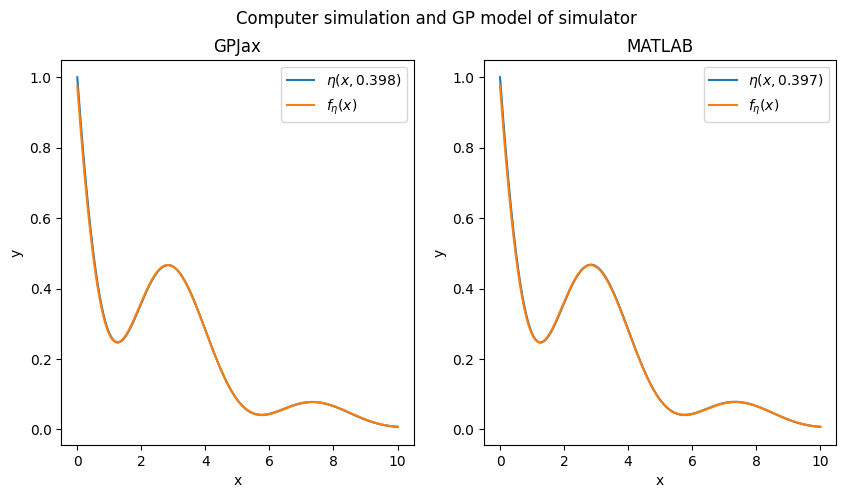

In [20]:
theta = params_transformed['theta']
theta_matlab = params_transformed_matlab['theta']

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

ax[0].plot(xpred, eta(xpred, theta), label=fr'$\eta(x, {theta:.3f})$')
ax[0].plot(xpred, eta_pred_m, label=r'$f_\eta(x)$')
ax[0].fill_between(
    xpred, 
    eta_pred_m-1.96*eta_pred_sd, 
    eta_pred_m+1.96*eta_pred_sd, 
    alpha=0.5, 
    color='orange'
)
ax[0].legend()
ax[0].set_xlabel("x")
ax[0].set_ylabel("y")
ax[0].set_title("GPJax")

ax[1].plot(xpred, eta(xpred, theta_matlab), label=fr'$\eta(x, {theta_matlab:.3f})$')
ax[1].plot(xpred, eta_pred_m_matlab, label=r'$f_\eta(x)$')
ax[1].fill_between(
    xpred, 
    eta_pred_m_matlab-1.96*eta_pred_sd_matlab, 
    eta_pred_m_matlab+1.96*eta_pred_sd_matlab, 
    alpha=0.5, 
    color='orange'
)
ax[1].legend()
ax[1].set_xlabel("x")
ax[1].set_ylabel("y")
ax[1].set_title("MATLAB")

fig.suptitle("Computer simulation and GP model of simulator")
plt.show()

## Plot GP modelling true process

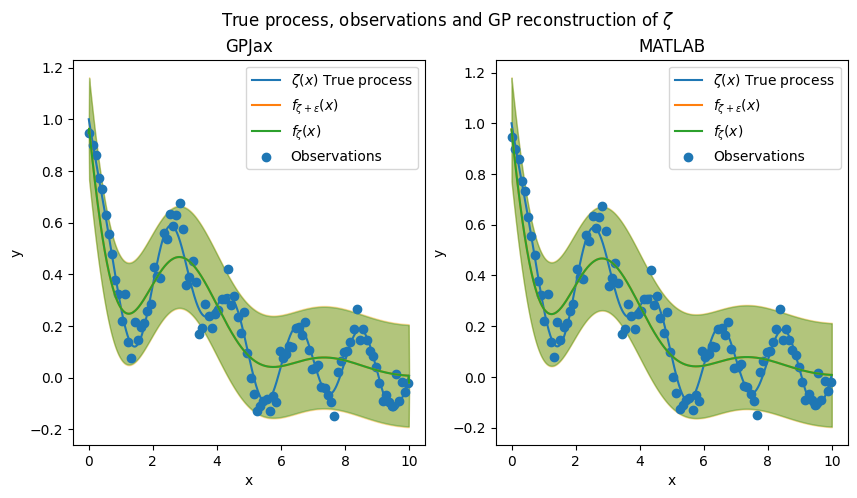

In [21]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

ax[0].plot(xpred, zeta(xpred)+disc(xpred), label=r'$\zeta(x)$ True process')
ax[0].plot(xpred, obs_pred_m, label=r'$f_{\zeta+\epsilon}(x)$')
ax[0].fill_between(
    xpred, 
    obs_pred_m-1.96*obs_pred_sd, 
    obs_pred_m+1.96*obs_pred_sd, 
    alpha=0.3, 
    color='orange'
)
ax[0].plot(xpred, zeta_pred_m, label=r'$f_{\zeta}(x)$')
ax[0].fill_between(
    xpred, 
    zeta_pred_m-1.96*zeta_pred_sd, 
    zeta_pred_m+1.96*zeta_pred_sd, 
    alpha=0.3, 
    color='green'
)
ax[0].scatter(dataloader.xf, dataloader.yf, label="Observations")
ax[0].legend()
ax[0].set_xlabel("x")
ax[0].set_ylabel("y")
ax[0].set_title("GPJax")

ax[1].plot(xpred, zeta(xpred)+disc(xpred), label=r'$\zeta(x)$ True process')
ax[1].plot(xpred, obs_pred_m_matlab, label=r'$f_{\zeta+\epsilon}(x)$')
ax[1].fill_between(
    xpred, 
    obs_pred_m_matlab-1.96*obs_pred_sd_matlab, 
    obs_pred_m_matlab+1.96*obs_pred_sd_matlab, 
    alpha=0.3, 
    color='orange'
)
ax[1].plot(xpred, zeta_pred_m_matlab, label=r'$f_{\zeta}(x)$')
ax[1].fill_between(
    xpred, 
    zeta_pred_m_matlab-1.96*zeta_pred_sd_matlab, 
    zeta_pred_m_matlab+1.96*zeta_pred_sd_matlab, 
    alpha=0.3, 
    color='green'
)
ax[1].scatter(dataloader.xf, dataloader.yf, label="Observations")
ax[1].legend()
ax[1].set_xlabel("x")
ax[1].set_ylabel("y")
ax[1].set_title("MATLAB")

fig.suptitle("True process, observations and GP reconstruction of $\zeta$")
plt.show()

## Model discrepancy

Interpret the next figure as follows. "True discrepancy" is the actual difference between the functions used to generate the simulation output and the observations. The blue line is the function the code is trying to learn. According to the MCMC samples, $\delta(x)$ should be the blue line. $f_\delta(x)$ is the attempt to learn the blue line.

Notice the uncertainty of the GP is very large and always encompases the true discrepancy function, $0$ for all $x$.

In [22]:
delta_gp_m = zeta_pred_m - eta_pred_m
delta_gp_v = zeta_pred_v + eta_pred_v
delta_gp_sd = np.sqrt(delta_gp_v)

delta_gp_m_matlab = zeta_pred_m_matlab - eta_pred_m_matlab
delta_gp_v_matlab = zeta_pred_v_matlab + eta_pred_v_matlab
delta_gp_sd_matlab = np.sqrt(delta_gp_v_matlab)

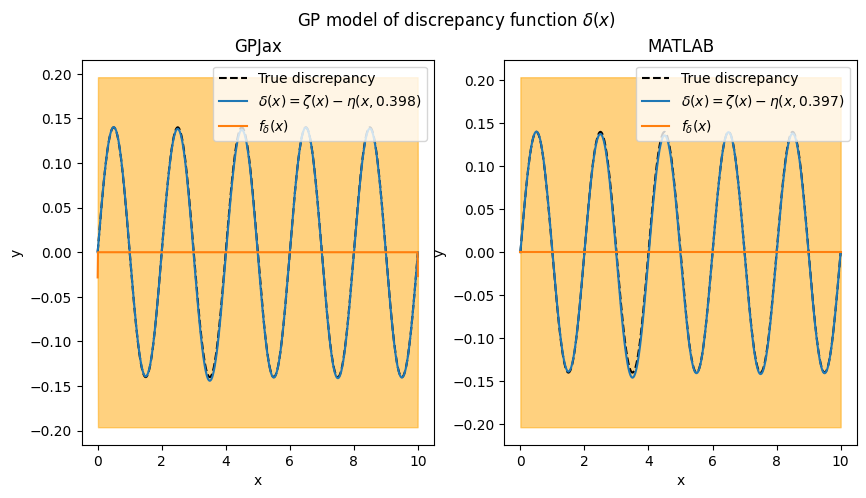

In [23]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

ax[0].plot(xpred, disc(xpred), color='black', linestyle='--', label='True discrepancy')
ax[0].plot(xpred, zeta(xpred)+disc(xpred) - eta(xpred, theta), label=rf'$\delta(x) = \zeta(x) - \eta(x, {theta:.3f})$')
ax[0].plot(xpred, delta_gp_m, label=r'$f_\delta(x)$')
ax[0].fill_between(
    xpred, 
    delta_gp_m-1.96*delta_gp_sd, 
    delta_gp_m+1.96*delta_gp_sd, 
    alpha=0.5, 
    color='orange'
)
ax[0].legend()
ax[0].set_xlabel("x")
ax[0].set_ylabel("y")
ax[0].set_title("GPJax")

ax[1].plot(xpred, disc(xpred), color='black', linestyle='--', label='True discrepancy')
ax[1].plot(xpred, zeta(xpred)+disc(xpred) - eta(xpred, theta_matlab), label=rf'$\delta(x) = \zeta(x) - \eta(x, {theta_matlab:.3f})$')
ax[1].plot(xpred, delta_gp_m_matlab, label=r'$f_\delta(x)$')
ax[1].fill_between(
    xpred, 
    delta_gp_m_matlab-1.96*delta_gp_sd_matlab, 
    delta_gp_m_matlab+1.96*delta_gp_sd_matlab, 
    alpha=0.5, 
    color='orange'
)
ax[1].legend()
ax[1].set_xlabel("x")
ax[1].set_ylabel("y")
ax[1].set_title("MATLAB")

fig.suptitle("GP model of discrepancy function $\delta(x)$")
plt.show()